In [1]:
import numpy as np
import sys
import os
import torch
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

dframe = pd.DataFrame

#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/heka/code/retrieval_app


# Query image plot:

#### Load model:

In [6]:
from core.models import SuperModel

supermodel = SuperModel()

/home/heka/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Load database:

In [7]:
from core.dataio import Database
from core.dataio import image_from_url
from core.augs import load_augs
from pprint import pprint
from detectron2.data import MetadataCatalog, DatasetCatalog

catalog = MetadataCatalog.get('coco_2017_train_panoptic_separated')
thing_classes = catalog.thing_classes
stuff_classes = catalog.stuff_classes
imagenet_classes = pd.read_csv('/home/heka/code/simclr-converter/metadata/imagenet_classes.txt', header=None, index_col=[0])

db_path = '/home/heka/database/test_50k.h5'
database = Database(db_path, mode='r', title=None)

augs = load_augs(resize_to=256)

index=50070
{'global_code': False,
 'h_center': 0.6484,
 'is_thing': False,
 'prediction_image': 466,
 'prediction_item': 25,
 'url': b'https://c4.staticflickr.com/9/8607/16316763889_aa8e92fa39_z.jpg',
 'w_center': 0.2}


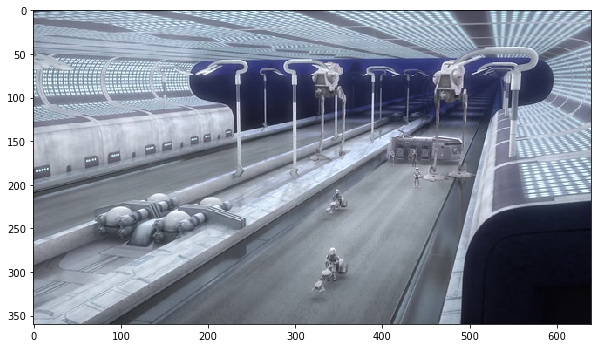

In [8]:
i = np.random.randint(100000)
#i = 60449
print(f'index={i}')

code, entity = database[i]
pprint(entity)

prediction_item = entity['prediction_item']
prediction_image = entity['prediction_image']
is_thing = entity['is_thing']
if prediction_item >= 0:
    pred_item = thing_classes[prediction_item] if is_thing else stuff_classes[prediction_item]
else:
    pred_item = None

img = image_from_url(entity['url'])
#img = augs['augs_base'](img)
img_np = np.array(img)
h, w = img_np.shape[:-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_np)
plt.show()


/home/heka/anaconda3/lib/python3.7/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


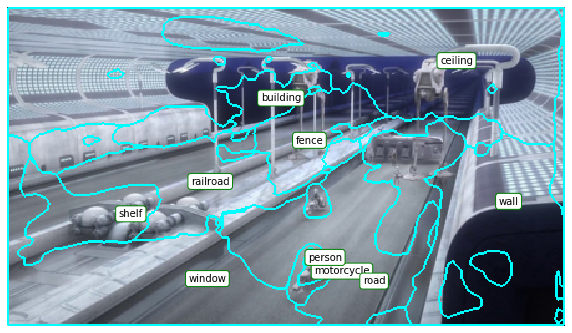

In [9]:
# data from supermodel:
img = image_from_url(entity['url'])
img_aug = augs['augs_base'](img)  # stil pil
img_np = np.array(img_aug)
from skimage.segmentation import find_boundaries

results = supermodel(img_aug)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.imshow(img_np)
ax.imshow(np.array(img_aug))
ax.set_xticks([])
ax.set_yticks([])

seg_masks = list()
centers = list()
for key, vals in results.items():
    if key == 0:
        continue  # display nothing for global code
    #_, h_center, w_center, pred_item, is_thing, seg_mask = vals
    h_center = vals['h']
    w_center = vals['w']
    pred_item = vals['pred']
    is_thing = vals['is_thing']
    seg_mask = vals['seg_mask']
    seg_masks.append(seg_mask)
    #seg_mask = seg_mask.astype(np.float32)
    #seg_mask[seg_mask < 1] = np.nan
    seg_mask_b = find_boundaries(seg_mask, mode='thick').astype(np.float32)
    seg_mask_b[seg_mask_b < 1] = np.nan
    w_center = int(w_center * img_aug.width)
    h_center = int(h_center * img_aug.height)
    centers.append((w_center, h_center))
    #pred_item = thing_classes[pred_item] if is_thing else stuff_classes[pred_item]
    #ax.scatter(w_center, h_center, s=500, c='r', marker='o', alpha=0.3)
    ax.imshow(seg_mask_b, alpha=.99, cmap='cool')# if is_thing else None
    text_dict = dict(boxstyle = "round", fc = "white", ec = "green")
    #ax.annotate(key, (w_center - 2, h_center + 2), bbox = text_dict)
    ax.annotate(pred_item, (w_center - 2, h_center + 2), bbox = text_dict)
    ax.set_axis_off()

plt.show()
fig.savefig('testfig.jpg', bbox_inches='tight', pad_inches=0)

### Smoother masks:
- get connected components
- select connected component containing visual center
- smoothen

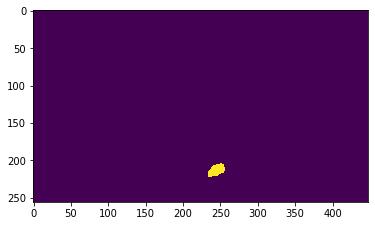

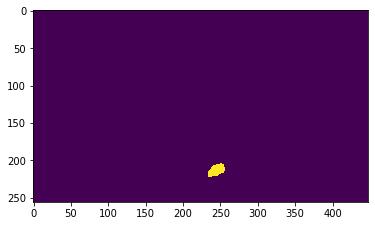

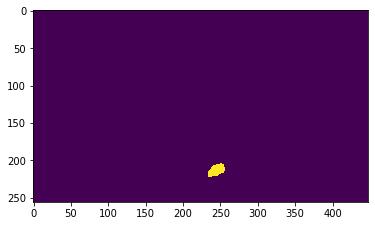

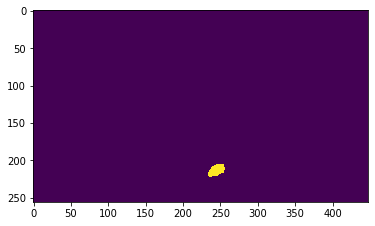

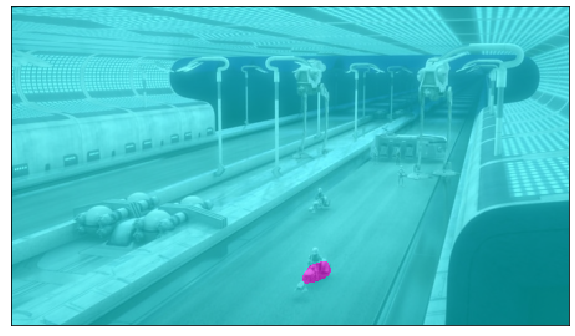

In [10]:
import copy
import skimage
from skimage.filters import gaussian

i = 0

test_mask = copy.deepcopy(seg_masks[i])
w, h = centers[i]
labels = skimage.measure.label(test_mask, return_num=False)

plt.imshow(test_mask)
plt.show()

# Get connected components:
plt.imshow(labels)
plt.show()

# Choose connected component containing visual center:
label_at_center = labels[h, w]
mask_around_center = labels == label_at_center

plt.imshow(mask_around_center)
plt.show()

# Smoothen:
mask_area = mask_around_center.sum()
mask_smooth = gaussian(mask_around_center, sigma=np.sqrt(mask_area) / 8)
mask_smooth = (mask_smooth > 0.5).astype(float)
#mask_smooth[mask_smooth < 1] = np.nan

# Connected comps again and select center one:
labels_smooth = skimage.measure.label(mask_smooth, return_num=False)
label_smooth_at_center = labels_smooth[h, w]
mask_smooth_around_center = labels_smooth == label_smooth_at_center

plt.imshow(mask_smooth_around_center)
plt.show()

# Plot with image:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.imshow(img_np)
ax.imshow(np.array(img_aug))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(mask_smooth_around_center, alpha=.5, cmap='cool')
plt.show()

In [11]:
def get_mask_around_center(mask, center, smooth_scale=1.):
    
    # Get connected components:
    w, h = center
    labels = skimage.measure.label(mask, return_num=False)

    # Choose connected component containing visual center:
    label_at_center = labels[h, w]
    mask_around_center = labels == label_at_center

    # Smoothen:
    mask_area = mask_around_center.sum()
    mask_smooth = gaussian(mask_around_center, sigma=smooth_scale * np.sqrt(mask_area) / 8)
    mask_smooth = (mask_smooth > 0.5).astype(float)

    # Connected comps again and select center one:
    labels_smooth = skimage.measure.label(mask_smooth, return_num=False)
    label_smooth_at_center = labels_smooth[h, w]
    mask_smooth_around_center = labels_smooth == label_smooth_at_center
    
    return mask_smooth_around_center

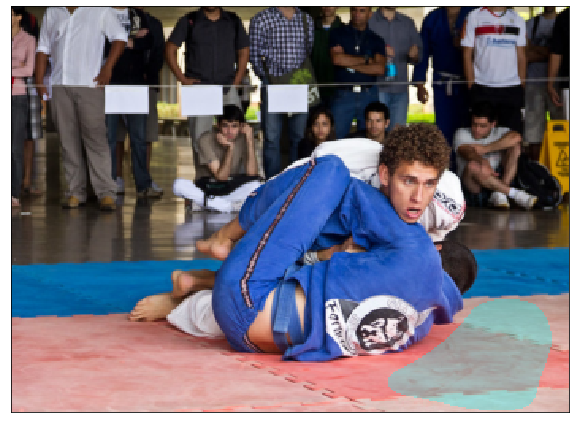

In [781]:
import copy
import skimage
from skimage.filters import gaussian

i = 7

test_mask = copy.deepcopy(seg_masks[i])
w, h = centers[i]

mask_smooth_around_center = get_mask_around_center(test_mask, centers[i], smooth_scale=1.).astype(float)
mask_smooth_around_center[mask_smooth_around_center < 0.5] = np.nan


# Plot with image:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.imshow(img_np)
ax.imshow(np.array(img_aug))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(mask_smooth_around_center, alpha=.3, cmap='cool')
plt.show()

In [770]:
%timeit get_mask_around_center(test_mask, centers[i], smooth_scale=1.)

7.61 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


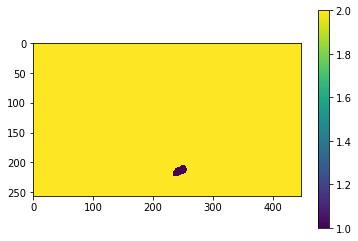

In [16]:
plt.imshow(test_mask)
plt.colorbar()
plt.show()

In [14]:
test_mask = test_mask.astype(float)
test_mask[test_mask < 0.5] = 2



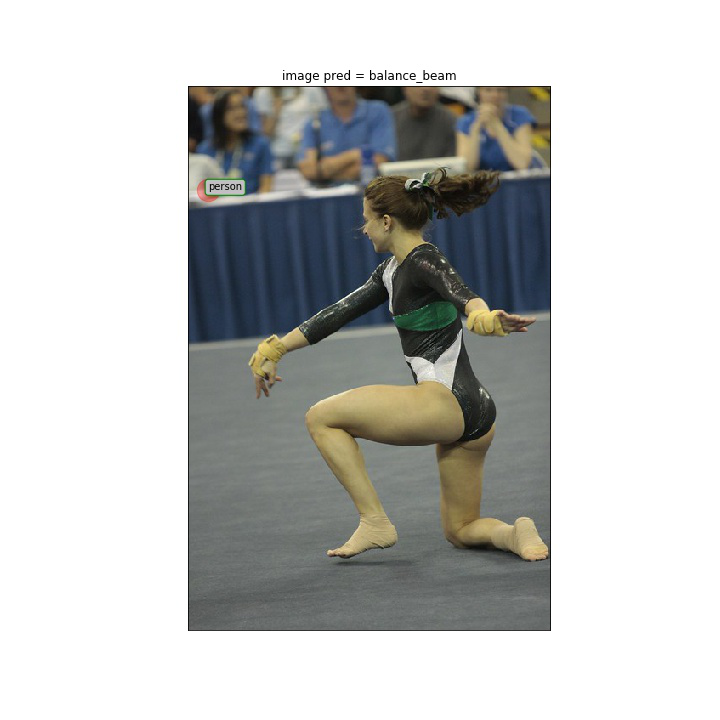

In [72]:
img = Image.open(buf)
img

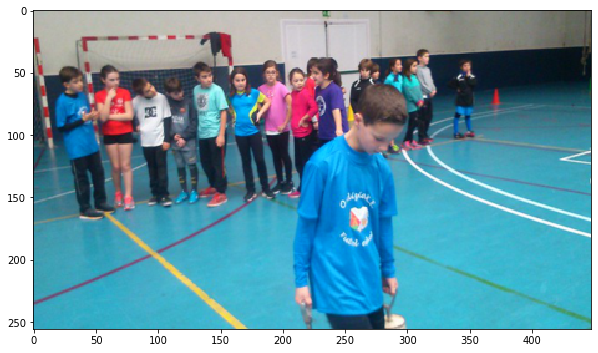

In [218]:
img = image_from_url(entity['url'])
img_aug = augs['augs_base'](img)  # stil pil
img_np = np.array(img_aug)
from skimage.segmentation import find_boundaries

results = supermodel(img_np)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_np)


## Test db:

In [427]:
from core.dataio import Database
from core.dataio import image_from_url
from core.augs import load_augs
from pprint import pprint
from detectron2.data import MetadataCatalog, DatasetCatalog

#db_path = '/home/heka/database/test_1k_new.h5'
db_path = '/home/heka/database/test_1k_new.h5'
db_path = '/home/heka/code/retrieval_app/database/open-images-dataset-train0_0_1000.h5'
database = Database(db_path, mode='r', title=None)

augs = load_augs(resize_to=256)

index=787
{'h': 0.3516,
 'is_thing': True,
 'pred': b'person',
 'url': b'https://farm4.staticflickr.com/3493/3786080126_bc0698b97b_z.jpg',
 'w': 0.6357}


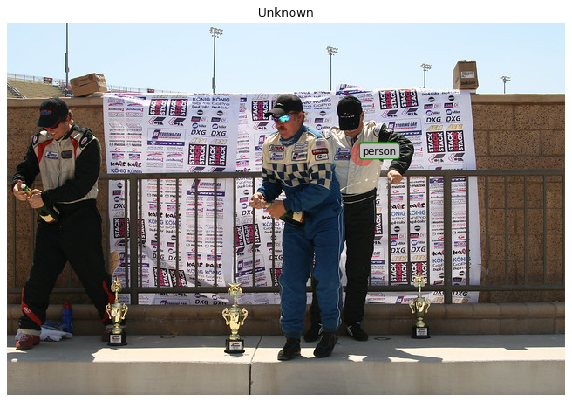

In [535]:
i = np.random.randint(1000)
#i = 60  # big crowd, good for sanity check
#i = 614
print(f'index={i}')

code, entity = database[i]
pprint(entity)

pred = str(entity['pred'], encoding='utf-8')
is_thing = entity['is_thing']

img = image_from_url(entity['url'])
#img = augs['augs_base'](img)
img = np.array(img)
h, w = img.shape[:-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
ax.imshow(img)
plot_title = f"{pred}" if entity['h'] < 0 else "Unknown"
ax.set_title(plot_title)
if entity['h'] > 0.:
    text_dict = dict(boxstyle = "round", fc = "silver", ec = "green")
    w_center = entity['w'] * w
    h_center = entity['h'] * h
    ax.scatter(w_center, h_center, s=500, c='r', marker='o', alpha=0.3)
    ax.annotate(pred, (w_center, h_center), bbox = text_dict)
else:
    print('GLOBAL CODE')
plt.show()


In [425]:
import torch
# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

[autoreload of core.models failed: Traceback (most recent call last):
  File "/home/heka/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/heka/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/heka/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/heka/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/heka/code/retrieval_app/core/models.py", line 19, in <module>
    from core.utils import visualize_segmentations, compute_visual_center, load_gcs_checkpoint, blob_to_path
Im

['resnest101',
 'resnest200',
 'resnest269',
 'resnest50',
 'resnest50_fast_1s1x64d',
 'resnest50_fast_1s2x40d',
 'resnest50_fast_1s4x24d',
 'resnest50_fast_2s1x64d',
 'resnest50_fast_2s2x40d',
 'resnest50_fast_4s1x64d',
 'resnest50_fast_4s2x40d']

## Combine databases:

In [15]:
db = Database('/home/heka/database/test.h5', mode='r', title=None)

Trying to load database from /home/heka/database/test.h5


In [2]:
from core.dataio import Database
from core.dataio import image_from_url
from core.augs import load_augs
from os.path import join
from pprint import pprint
import tables as tb


db_root = '/home/heka/database'

if 0:
    db_names = [
        'open-images-dataset-train0_0_100000.h5',
        'open-images-dataset-train0_100000_225000.h5',
        'open-images-dataset-train0_225000_350000.h5',
        'open-images-dataset-train0_350000_475000.h5'
    ]
if 0:
    db_names = ['open-images-dataset-train1_0_1000000_copy.h5',
                'open-images-dataset-train0_0_475000.h5']

databases = [Database(join(db_root, db_name), mode='r', title=None) for db_name in db_names]

NameError: name 'db_names' is not defined

In [6]:
# folder based:
from core.dataio import Database
from core.augs import load_augs
import os
from os.path import join
from pprint import pprint
import tables as tb


db_root = '/home/heka/database'

db_names = os.listdir(db_root)
db_names = [db_name for db_name in db_names if '.h5' in db_name]

databases = [Database(join(db_root, db_name), mode='r', title=None) for db_name in db_names]

# WARNING: will open the first database and will IMMEDIATELY begin writing to it, so will get screwed up if interrupted!
database = databases[0]
for i, database_other in enumerate(databases[1:]):
    print(f'\r{i}/{len(databases[1:])}', end='')
    database.cat(database_other)
    
#[db.close() for db in databases]

Trying to load database from /home/heka/database/open-images-dataset-train4_0_2000000_54b569be451e11eb.h5
Trying to load database from /home/heka/database/open-images-dataset-train4_0_2000000_52f6c4e2451e11eb.h5
0/1

FileModeError: the file is not writable

In [14]:
database.entities['url']

b''

In [8]:

h5file = tb.open_file(join(db_root, 'open-images-dataset-train1_0_1000000_copy.h5'), mode='r')

In [6]:
h5file = tb.open_file(join(db_root, 'open-images-dataset-train0_0_475000.h5'), mode='r')

In [9]:
h5file.root

/ (RootGroup) ''
  children := []

In [5]:
# WARNING: will open the first database and will IMMEDIATELY begin writing to it, so will get screwed up if interrupted!
database = databases[0]
for i, database_other in enumerate(databases[1:]):
    print(f'\r{i}/{len(databases[1:])}', end='')
    database.cat(database_other)

0/3Done.
1/3Done.
2/3Done.


In [25]:
import numpy as np

N = 10
idx = np.arange(N)
vals = np.random.randint(0, 128, size=(N))
val_dct = dict(zip(idx, vals))

In [30]:
idx_this = np.random.choice(idx)
val_this = val_dct[idx_this]

print(val_this)

92


In [36]:
np.random.choice(idx)

8

In [42]:
N = 1000000
idx = np.arange(N)
%timeit np.random.choice(idx)

5.54 µs ± 34.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Test loading unfinished databases:

In [19]:
from core.dataio import Database
from core.augs import load_augs
from os.path import join
from pprint import pprint
import tables as tb

In [28]:
db_root = '/home/heka/Downloads'
db_name = 'database_open-images-dataset-train3_0_1000_e047251c451911eb.h5'  # small
db_name = 'database_open-images-dataset-train4_0_2000000_54b569be451e11eb.h5'

database = Database(join(db_root, db_name), mode='r', title=None)

Trying to load database from /home/heka/Downloads/database_open-images-dataset-train4_0_2000000_54b569be451e11eb.h5


In [29]:
database[0]

(array([-7.2168e-01,  1.3135e-01,  7.1533e-02,  7.3792e-02, -1.7151e-02,
         6.4316e-03, -8.0322e-02, -6.4880e-02,  1.2323e-01, -6.4026e-02,
        -9.0454e-02, -2.5244e-01, -1.3818e-01, -4.6722e-02,  2.1521e-01,
        -2.3206e-01,  1.8054e-01, -2.5314e-02, -1.8469e-01, -1.0492e-01,
        -7.6660e-02,  1.3519e-02,  1.1609e-01,  3.3667e-01,  1.4702e-02,
         5.9662e-02, -6.0883e-02,  6.3416e-02,  5.0537e-02, -3.5059e-01,
        -1.0547e-01, -1.6992e-01,  1.5662e-01,  2.3499e-02, -2.8580e-02,
        -1.2720e-01, -1.5335e-02, -1.7136e-02,  1.0950e-01, -1.1151e-01,
        -9.9243e-02, -2.2058e-01, -1.7651e-01, -1.4526e-01, -3.9368e-02,
        -6.1584e-02, -2.0422e-01, -2.1301e-01, -1.2347e-01, -2.8516e-01,
         1.1681e-02,  2.4158e-01,  1.1896e-01,  1.7639e-01, -9.8999e-02,
        -1.5662e-01, -1.1194e-01, -2.6147e-01, -5.9540e-02, -1.2054e-01,
         8.9722e-02,  1.4673e-01, -1.7822e-01,  1.1749e-01,  2.1045e-01,
        -1.5015e-01, -3.3173e-02,  2.7710e-01, -1.1

In [42]:
database.codes

/codes (EArray(144429, 128)) ''
  atom := Float16Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (512, 128)

In [43]:
database.table

/entities (Table(144429,)) 'Entity metadata'
  description := {
  "h": Float16Col(shape=(), dflt=0.0, pos=0),
  "is_thing": BoolCol(shape=(), dflt=False, pos=1),
  "pred": StringCol(itemsize=32, shape=(), dflt=b'', pos=2),
  "url": StringCol(itemsize=64, shape=(), dflt=b'', pos=3),
  "w": Float16Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (648,)

In [ ]:
from core.utils import images_from_urls

urls = ['https://c8.staticflickr.com/5/4012/4493750610_d26c8bec84_z.jpg',
       'https://farm3.staticflickr.com/1377/4726389211_8d7459224a_z.jpg',
       'https://farm3.staticflickr.com/5578/14849739690_e98d32a4b2_z.jpg',
       'https://farm4.staticflickr.com/8144/7590702684_bfb452df3d_z.jpg']

imgs = images_from_urls(urls)